Run this script to compute or plot potential energy surface color-coded for photonic/excitonic contribution for different cavity parameters.

In [1]:
### Import all libraries and define various parameters here!
import numpy as np
from polaritonic import polaritonic
from numpy import linalg as LA
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

The following cell will actually compute the derivative coupling and write it to a file.  
You can change the $\gamma$ parameter (via the `gamp=X` line) and the filename (via `prefix = Y` line) here!

In [5]:
ri_init = -0.66156
vi_init = 3.3375e-5
'''NOTE 1:  when you change gamp, you change the lifetime in Hamiltonian!'''
### lifetime
gamp = 0.
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
gp = 0.02
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
'''NOTE 2:  when you prefix, it will change the file name that the data is written to, and in the next cell that 
   plots the data, this file name will automatically be read from.  Make sure you change the prefix accordingly each 
   time you change the gamp parameter.'''
prefix = "gam_0.0"
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'

### hellman-Feynman file 
hf_fn = "Data/" + prefix + "_hf.txt"
dc_fn = "Data/" + prefix + "_dc.txt"
ip_fn = "Data/" + prefix + "_ip.txt"
ptdc_fn = "Data/" + prefix + "_ptdc.txt"
filename = prefix + ".eps"

options = {
        'Number_of_Photons': 1,
        'Complex_Frequency': True,
        'Photon_Energys': [omc],
        'Coupling_Strengths': [gc], 
        'Photon_Lifetimes': [gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)
### write forces and derivative coupling
#polt.Transform_L_to_P()



Initialize R, find local slope and curvature of each surface, then compute the global surfaces with 
correct ordering and write them to data files.

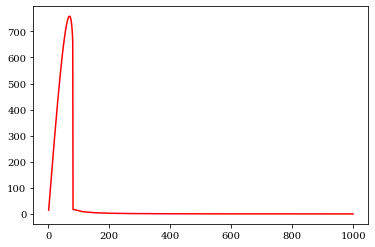

In [6]:
Nv = 1000
hg = 0.02 #np.linspace(0.01, 0.2, Nv)
hgam = np.linspace(1, 1000, Nv)

mag_abs = np.zeros(Nv)
mag_re = np.zeros(Nv)
mag_im = np.zeros(Nv)

for i in range(0, Nv):
    c_val = hg / 27.211
    gamma_val = hgam[i] * 1e-3 / 27.211

        
    options['Photon_Lifetimes'] = [gamma_val]
    options['Coupling_Strengths'] =  [c_val]
        
    polt = polaritonic(options)
    #polt.gamma_photon = 1000 * 1e-3 / 27.211
    polt.R = -1.25
    ### get local slope curvature of each surface at R = -1.25
    polt.init_slope_and_curve()
    ### write the potential energy surfaces, the derivative couplings, and the polaritonic inner-product and left/right
    ### eigenvector data to files
    polt.Write_PES(pes_fn, pc_fn, dc_fn, ptdc_fn, ip_fn)
    dc = np.loadtxt(dc_fn,dtype=complex)
    spline_axis = np.real(dc[:,0])
    eval_spline = np.linspace(-1.5, 0, 200)
        
    #re_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,1]), k=3)
    #im_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,1]), k=3)
    re_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,2]), k=3)
    im_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,2]), k=3)
        
    abs_list = (re_dc_32_spline(eval_spline)**2 + im_dc_32_spline(eval_spline)**2)**(0.5)
    re_list = np.abs(re_dc_32_spline(eval_spline))
    im_list = np.abs(im_dc_32_spline(eval_spline))
    #print(np.amax(abs_list))
    mag_abs[i] = np.amax(abs_list)
    mag_re[i] = np.amax(re_list)
    mag_im[i] = np.amax(im_list)
    
plt.plot(hgam, mag_im, 'red')
plt.show()
    

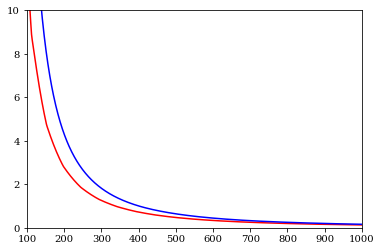

In [11]:
plt.plot(hgam, mag_im, 'red')
plt.plot(hgam, mag_re, 'blue')
#plt.plot(hgam, mag_abs, 'green')
plt.xlim(100,1000)
plt.ylim(0,10)
plt.show()

In [38]:
Nv = 20
hg = np.linspace(0.01, 0.2, Nv)
hgam = np.linspace(0.1, 100, Nv)

mag_abs = np.zeros((Nv,Nv))
mag_re = np.zeros((Nv,Nv))
mag_im = np.zeros((Nv,Nv))

for i in range(0, Nv):
    c_val = hg[i] / 27.211
    for j in range(0, Nv):
        gamma_val = hgam[j] * 1e-3 / 27.211

        
        options['Photon_Lifetimes'] = [gamma_val]
        options['Coupling_Strengths'] =  [c_val]
        
        polt = polaritonic(options)
        #polt.gamma_photon = 1000 * 1e-3 / 27.211
        polt.R = -1.25
        ### get local slope curvature of each surface at R = -1.25
        polt.init_slope_and_curve()
        ### write the potential energy surfaces, the derivative couplings, and the polaritonic inner-product and left/right
        ### eigenvector data to files
        polt.Write_PES(pes_fn, pc_fn, dc_fn, ip_fn)
        dc = np.loadtxt(dc_fn,dtype=complex)
        spline_axis = np.real(dc[:,0])
        eval_spline = np.linspace(-1.5, 0, 200)
        
        #re_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,1]), k=3)
        #im_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,1]), k=3)
        re_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,2]), k=3)
        im_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,2]), k=3)
        
        abs_list = (re_dc_32_spline(eval_spline)**2 + im_dc_32_spline(eval_spline)**2)**(0.5)
        re_list = np.abs(re_dc_32_spline(eval_spline))
        im_list = np.abs(im_dc_32_spline(eval_spline))
        #print(np.amax(abs_list))
        mag_abs[i,j] = np.amax(abs_list)
        mag_re[i,j] = np.amax(re_list)
        mag_im[i,j] = np.amax(im_list)
    

#plt.plot(hg, mag_abs, 'black', label='abs')
#plt.plot(hg, mag_re, 'red', label='re')
#plt.plot(hg, mag_im, 'blue', label='im')
#plt.legend()
#plt.show()
#print("max is ",m)
##plt.plot(spline_axis, im_dc_23_spline(spline_axis), 'red')
#plt.plot(eval_spline, (re_dc_32_spline(eval_spline)**2 + im_dc_32_spline(eval_spline)**2)**(0.5), 'b--')
##plt.xlim(0.2,0.5)
#plt.show()
#polt.Initialize_Phase_Space()
#print(polt.V)



scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex con

scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex con

scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex condition True
scaling condition True
complex con

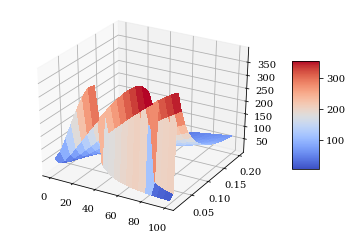

In [40]:
#hg = np.linspace(0.01, 0.2, Nv)
#hgam = np.linspace(0.1, 100, Nv)

#mag_abs = np.zeros((Nv,Nv))
#mag_re = np.zeros((Nv,Nv))
#mag_im = np.zeros((Nv,Nv))
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(hgam, hg)
surf = ax.plot_surface(X, Y, mag_abs, cmap=cm.coolwarm, 
                      linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=4)
plt.show()

Once the derivative coupling has been written to a file (or several have been written to a file), you can parse the files and plot them with the following cell!

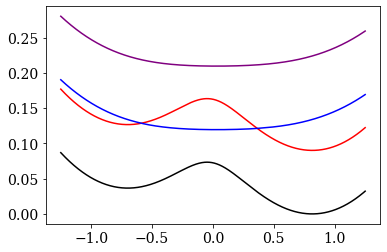

In [12]:
pes_v = np.loadtxt(pes_fn, dtype=complex)
spline_axis = np.real(pes_v[:,0])
pc_v = np.loadtxt(pc_fn,dtype=complex)
 
# g0
re_g0_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,1]), k=3)
im_g0_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,1]), k=3)

# LP
re_LP_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,2]), k=3)
im_LP_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,2]), k=3)

# UP
re_UP_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,3]), k=3)
im_UP_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,3]), k=3)

# e1
re_e1_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,4]), k=3)
im_e1_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,4]), k=3)


plt.plot(spline_axis, re_g0_spline(spline_axis), 'black')
plt.plot(spline_axis, re_LP_spline(spline_axis), 'red')
plt.plot(spline_axis, re_UP_spline(spline_axis), 'blue')
plt.plot(spline_axis, re_e1_spline(spline_axis), 'purple')
plt.show()

#plt.plot(pes_v[:,0], 27.211*np.real(pes_v[:,2]), 'blue')
#plt.plot(pes_v[:,0], np.imag(pes_v[:,2]), 'b*')
#plt.plot(pes_v[:,0], np.imag(pes_v[:,3]), 'r*')
#plt.plot(pes_v[:,0], 27.211*np.real(pes_v[:,3]), 'red')
#plt.xlim(-0.7,-0.5)
#plt.ylim(3.2, 4.02)
#plt.show()



dc matrix
[[  0.        +0.j           0.        +0.j
    0.        +0.j           0.        +0.j        ]
 [  0.        +0.j           0.        +0.j
  -38.35794132+0.03731562j   0.        +0.j        ]
 [  0.        +0.j          34.95616846-0.00547903j
    0.        +0.j           0.        +0.j        ]
 [  0.        +0.j           0.        +0.j
    0.        +0.j           0.        +0.j        ]]
ham matrix
[[0.03034708-3.03083217e-11j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.11997435-1.39681732e-06j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.12169575-4.40674869e-07j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.21132303-1.83746188e-06j]]
initial wavefunction
[0.+0.j 0.+0.j 1.+0.j 0.+0.j]


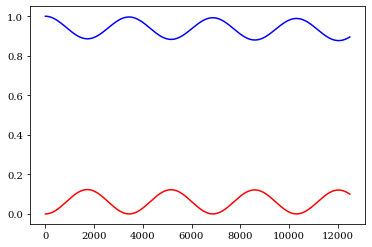

[0.        +0.j         0.24920872+0.19511829j 0.20674641-0.92317188j
 0.        +0.j        ]


In [13]:
ci=0+1j
polt.R = 0.37
n_time = 500000
t_array = np.zeros(n_time)
pop = np.zeros((2,n_time))

polt.H_polariton = np.zeros((4,4),dtype=complex)
polt.dc[1,2] = re_dc_23_spline(polt.R) + im_dc_23_spline(polt.R)*ci
polt.dc[2,1] = re_dc_32_spline(polt.R) + im_dc_32_spline(polt.R)*ci

print("dc matrix")
print(polt.dc)

polt.H_polariton[0,0] = re_g0_spline(polt.R)+ci*im_g0_spline(polt.R)
polt.H_polariton[1,1] = re_LP_spline(polt.R)+ci*im_LP_spline(polt.R)
polt.H_polariton[2,2] = re_UP_spline(polt.R)+ci*im_UP_spline(polt.R)
polt.H_polariton[3,3] = re_e1_spline(polt.R)+ci*im_e1_spline(polt.R)

print("ham matrix")
print(polt.H_polariton)

print("initial wavefunction")
print(polt.C_polariton)

for i in range(0,n_time):
    t_array[i] = i*polt.dt
    polt.RK4_NH_SE()
    #print("new pop LP ",i)
    pop[0,i] = np.real(np.conj(polt.C_polariton[1])*polt.C_polariton[1])
    #print("new pop UP ",i)
    pop[1,i] = np.real(np.conj(polt.C_polariton[2])*polt.C_polariton[2])
    
    
plt.plot(t_array, pop[0,:], 'red')
plt.plot(t_array, pop[1,:], 'blue')
plt.show()
#polt.RK4_NH_SE()

#print("new wavefunction 2")
#print(polt.C_polariton)
#print("new pop LP 2")
#print(np.conj(polt.C_polariton[1])*polt.C_polariton[1])
#print("new pop UP 2")
#print(np.conj(polt.C_polariton[2])*polt.C_polariton[2])
#polt.C_polariton = np.copy(polt.C_polariton + dcdt * polt.dt)

#dcdt = np.copy(-1*polt.V * np.dot(polt.dc, polt.C_polariton))
#polt.C_polariton = np.copy(polt.C_polariton + dcdt * polt.dt)


print(polt.C_polariton)


In [ ]:
# g0
re_g0_force = re_g0_spline.derivative()
im_g0_force = im_g0_spline.derivative()

# LP
re_LP_force = re_LP_spline.derivative()
im_LP_force = im_LP_spline.derivative()

# UP
re_UP_force = re_UP_spline.derivative()
im_UP_force = re_UP_spline.derivative()




plt.plot(spline_axis, -1*im_g0_force(spline_axis), 'black')
plt.plot(spline_axis, -1*im_LP_force(spline_axis), 'red')
plt.plot(spline_axis, -1*im_UP_force(spline_axis), 'blue')
#plt.plot(spline_axis, re_e1_spline(spline_axis), 'purple')
plt.show()

In [ ]:
polt.Write_Forces(hf_fn)

LP_force = re_LP_spline.derivative()
### read text file
dc = np.loadtxt(hf_fn,dtype=complex)

### plot the data!
plt.plot(dc[:,0], np.imag(dc[:,3]), 'red', label='$\gamma$=100 meV')
#plt.plot(dc[:,0], -1*LP_force(np.real(dc[:,0])), 'blue', label='$\gamma$=100 meV')
#plt.plot(dc[:,0], np.real(dc[:,1]), 'red', label='$\gamma$=100 meV')

#plt.plot(dc_1p0[:,0], np.imag(dc_1p0[:,3]), 'b--', label='$\gamma$=1.0 meV')
#plt.plot(dc_10p0[:,0], np.imag(dc_10p0[:,3]), 'g--', label='$\gamma$=10.0 meV')
plt.legend()
#plt.xlim(-0.75,0.5)
plt.xlabel("R (a.u.)")
plt.ylabel("Re $( d_{3,2} )$ (a.u.)")
plt.savefig("DC_abs.eps")
plt.show()

In [ ]:
### read text file

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,1]), c='black',s=1) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,2]), c=np.abs(np.imag(pes_v[:,2])),cmap=cm, s=1) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,3]), c=np.abs(np.imag(pes_v[:,3])),cmap=cm, s=1)
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=1)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1 ])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
#plt.xlim(-0.625,-0.55)
#plt.ylim(3.2, 4.02)
plt.xlim(-0.7,-0.5)
plt.ylim(3.2, 4.02)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
#plt.savefig(filename)
plt.show()



In [ ]:
### just playing around here
polt.R = -0.5
polt.H_e()
polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
polt.Transform_L_to_P('True')
print(polt.H_polariton[0,0])
print(polt.H_polariton[1,1])
print(polt.H_polariton[2,2])
print(polt.H_polariton[3,3])

In [ ]:
### read text file

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,1]), c='black', s=4) 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,2]), c=pc_v[:,2],cmap=cm, s=4) 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c=pc_v[:,3],cmap=cm, s=4)
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.0,1.0)
plt.ylim(-0.1,5.0)
plt.xlabel("$\Theta$ (a.u.)")
plt.ylabel("Energy (eV)")
plt.savefig(filename)
plt.show()


In [ ]:
fig, ax = plt.subplots()
#cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,1]), c='black', s=4, label='|g>') 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c='red',s=4, label='|e>') 
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c=pc_v[:,3],cmap=cm, s=4)
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.0,1.0)
plt.ylim(-0.1,5.0)
#plt.legend()
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
plt.savefig(filename)
plt.show()